In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

In [4]:
# Setup plotting sldkf
plotting.setup_mpl()

ff1.Cache.enable_cache('/Users/rahulrajagopal/Documents/PBL - RaceWiz AI/F1 data extraction')

pd.options.mode.chained_assignment = None 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastf1/plotting/_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastf1/plotting/_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


In [8]:
race = ff1.get_session(2024, 'São Paulo', 'R')
race.load()
laps = race.laps

laps_NOR = laps.pick_driver('NOR')
laps_VER = laps.pick_driver('VER')

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16'

In [17]:
laps_NOR = laps_NOR.loc[laps_NOR['Stint'] == 1]
laps_VER = laps_VER.loc[laps_VER['Stint'] == 1]
print(laps_NOR.columns)
print(laps_VER.columns)


Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')
Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='o

In [11]:
full_distance_NOR_VER_list = []
summarized_distance_VER_NOR_list = []

for lap in laps_VER.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "4"]
    
    if len(telemetry) != 0:
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry['Lap'] = lap[0] + 1
        full_distance_NOR_VER_list.append(lap_telemetry)
        
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])
        summarized_distance_VER_NOR_list.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        })

full_distance_NOR_VER = pd.concat(full_distance_NOR_VER_list, ignore_index=True)
summarized_distance_VER_NOR = pd.DataFrame(summarized_distance_VER_NOR_list)


In [19]:
def format_lap_time(timedelta):
    total_seconds = int(timedelta.total_seconds())
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    milliseconds = int(timedelta.microseconds / 1000)
    return f"{minutes}:{seconds:02}.{milliseconds:03}"

# Apply the formatting
laps_NOR['LapTime'] = pd.to_timedelta(laps_NOR['LapTime'])
laps_VER['LapTime'] = pd.to_timedelta(laps_VER['LapTime'])
laps_NOR['FormattedLapTime'] = laps_NOR['LapTime'].apply(format_lap_time)
laps_VER['FormattedLapTime'] = laps_VER['LapTime'].apply(format_lap_time)

ValueError: cannot convert float NaN to integer

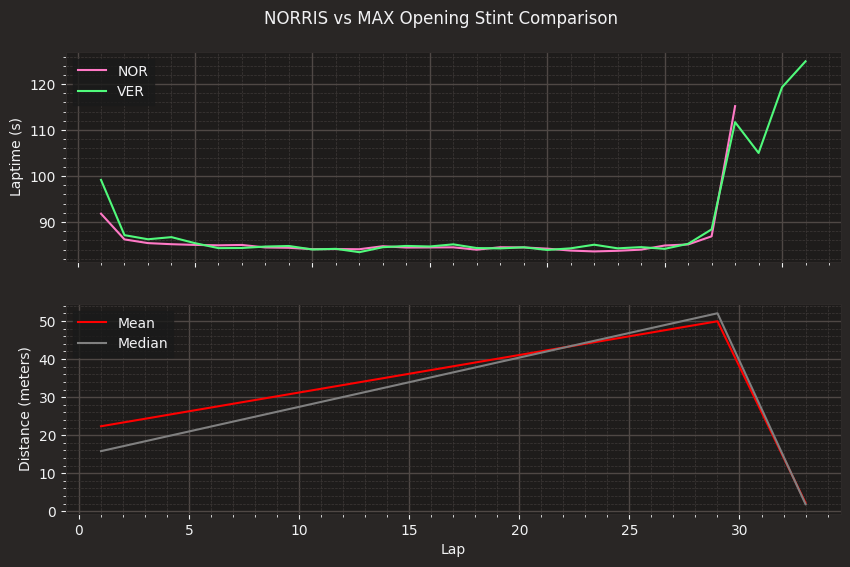

In [18]:

laps_NOR['LapTime'] = laps_NOR['LapTime'].dt.total_seconds()
laps_VER['LapTime'] = laps_VER['LapTime'].dt.total_seconds()

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots(2)
fig.suptitle("NORRIS vs MAX Opening Stint Comparison", y=0.95)

ax[0].plot(laps_NOR['LapNumber'], laps_NOR['LapTime'], label='NOR')
ax[0].plot(laps_VER['LapNumber'], laps_VER['LapTime'], label='VER')
ax[0].set(ylabel='Laptime (s)', xlabel='Lap')
ax[0].legend(loc="best")

ax[1].plot(summarized_distance_VER_NOR['Lap'], summarized_distance_VER_NOR['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_VER_NOR['Lap'], summarized_distance_VER_NOR['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="best")

for a in ax.flat:
    a.label_outer()

plt.show()
